In [1]:
import numpy as np # linear algebra
np.random.seed(1337) #reproducibility
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import os
import pandas as pd
import soundfile as sf
import scipy.signal as signal
import matplotlib.pyplot as plt
import gc
import IPython.display as ipd 

In [3]:
train_path = '../input/spoken-language-identification/train/train/'
test_path = '../input/spoken-language-identification/test/test/'

In [4]:
filename = 'de_f_0809fd0642232f8c85b0b3d545dc2b5a.fragment1.flac'

In [5]:
data, samplerate = sf.read(train_path+filename)

In [6]:
import os
print(os.listdir('../input'))
import pandas as pd

['spoken-language-identification']


In [7]:
import gc
gc.collect()

0

In [8]:
data.shape

(220500,)

In [9]:
#el flac cargado
data[:10]

array([-0.03903198, -0.03997803, -0.05319214, -0.06002808, -0.0531311 ,
       -0.04608154, -0.04348755, -0.02947998, -0.02307129, -0.02459717])

In [10]:
samplerate

22050

In [11]:
ipd.Audio(train_path+filename)

In [12]:
#freq, time, Sxx = signal.spectrogram(data, samplerate, scaling='spectrum')
#plt.pcolormesh(time, freq, Sxx)

## add axis labels
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time [sec]')

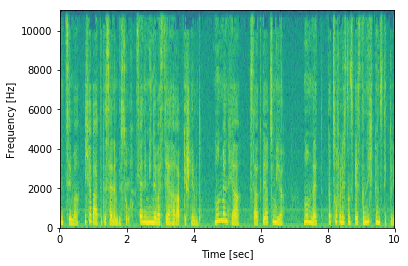

In [13]:
Pxx, freqs, bins, im = plt.specgram(data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

Text(0.5, 0, 'Time in samples')

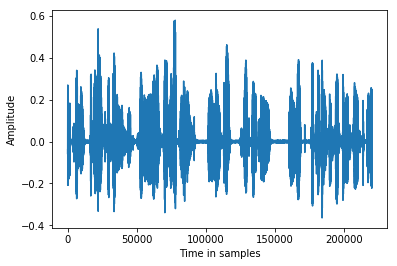

In [14]:
plt.plot(data)

# add axis labels
plt.ylabel('Amplitude')
plt.xlabel('Time in samples')

cargamos las labels de idiomas en label y label_t

In [15]:
filename[:2]

'de'

In [16]:
#para train path
label = []
for filename in os.listdir(train_path):
    label.append(filename[:2]) #es [:2] porque el idioma esta en los dos primeros elementos

In [17]:
#para test path
label_t = []
for filename in os.listdir(test_path):
    label_t.append(filename[:2])

In [18]:
print(len(label))
print(len(label_t))

73080
540


In [19]:
# gender = []
# for filename in os.listdir(train_path):
#     gender.append('male' if filename[3:4]=='m' else 'female')

In [20]:
# gender_t = []
# for filename in os.listdir(test_path):
#     gender_t.append('male' if filename[3:4]=='m' else 'female')

In [21]:
file = []
for filename in os.listdir(train_path):
    file.append(filename)

In [22]:
file_t = []
for filename in os.listdir(test_path):
    file_t.append(filename)

In [23]:
Label = pd.DataFrame(label,columns=['Language'])

Está balanceado el dataset:

In [24]:
Label['Language'].value_counts()

es    24360
de    24360
en    24360
Name: Language, dtype: int64

In [25]:
data = {'filename':file,
       'languange':label}

In [26]:
data_t = {'filename':file_t,
       'languange':label_t}

In [27]:
#df es el dataframe de train
df = pd.DataFrame(data)

In [28]:
#df_t es el dataframe de test
df_t = pd.DataFrame(data_t)

In [29]:
df['filename'][0]

'en_m_29119ce8a7ecbf970f9a0728087c8ac3.fragment2.noise10.flac'

In [30]:
#extraida de https://github.com/tomasz-oponowicz/spoken_language_identification
def generate_fb_and_mfcc(signal, sample_rate):

    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(
        signal[0],
        signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size = 0.025
    frame_stride = 0.01

    # Convert from seconds to samples
    frame_length, frame_step = (
        frame_size * sample_rate,
        frame_stride * sample_rate)
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))

    # Make sure that we have at least 1 frame
    num_frames = int(
        np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))

    # Pad Signal to make sure that all frames have equal
    # number of samples without truncating any samples
    # from the original signal
    pad_signal = np.append(emphasized_signal, z)

    indices = (
        np.tile(np.arange(0, frame_length), (num_frames, 1)) +
        np.tile(
            np.arange(0, num_frames * frame_step, frame_step),
            (frame_length, 1)
        ).T
    )
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Window
    frames *= np.hamming(frame_length)

    # Fourier-Transform and Power Spectrum
    NFFT = 512

    # Magnitude of the FFT
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # Power Spectrum
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # Filter Banks
    nfilt = 40

    low_freq_mel = 0

    # Convert Hz to Mel
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))

    # Equally spaced in Mel scale
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)

    # Convert Mel to Hz
    hz_points = (700 * (10**(mel_points / 2595) - 1))
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)

    # Numerical Stability
    filter_banks = np.where(
        filter_banks == 0,
        np.finfo(float).eps,
        filter_banks)

    # dB
    filter_banks = 20 * np.log10(filter_banks)

    # MFCCs
    # num_ceps = 12
    # cep_lifter = 22

    # ### Keep 2-13
    # mfcc = dct(
    #     filter_banks,
    #     type=2,
    #     axis=1,
    #     norm='ortho'
    # )[:, 1 : (num_ceps + 1)]

    # (nframes, ncoeff) = mfcc.shape
    # n = np.arange(ncoeff)
    # lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    # mfcc *= lift
    #filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)
    return filter_banks

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
### Splitting 73000 audio files to get enough files for training and for RAM

In [33]:
X_train,X_test,y_train,y_test = train_test_split(df,df['languange'],stratify = df['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    12180
es    12180
en    12180
Name: languange, dtype: int64
de    12180
es    12180
en    12180
Name: languange, dtype: int64


In [34]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    6090
es    6090
en    6090
Name: languange, dtype: int64
de    6090
es    6090
en    6090
Name: languange, dtype: int64


In [35]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.5,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

de    3045
en    3045
es    3045
Name: languange, dtype: int64
de    3045
en    3045
es    3045
Name: languange, dtype: int64


In [36]:
X_train,X_test,y_train,y_test = train_test_split(X_train,X_train['languange'],stratify = X_train['languange'],test_size = 0.6,random_state = 0)
print(X_train['languange'].value_counts())
print(X_test['languange'].value_counts())

en    1218
de    1218
es    1218
Name: languange, dtype: int64
de    1827
en    1827
es    1827
Name: languange, dtype: int64


In [37]:
X_train['filename'].values[:2]

array(['en_f_058b70233667e1b64506dddf9f9d6b46.fragment1.noise4.flac',
       'en_m_f7d28f7498eaf373b312abcdc0886951.fragment23.speed3.flac'],
      dtype=object)

In [38]:
X_train.head()

,filename,languange
49674,en_f_058b70233667e1b64506dddf9f9d6b46.fragment...,en
71876,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
47664,en_f_17211c49a9b2967b57cffaccf0d5b565.fragment...,en
12759,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en
58679,es_f_e27d922d06d483e4df1305235a6cd87b.fragment...,es


In [39]:
#reseteamos los indices
X_train = X_train.reset_index(drop = True)
X_train.head()

,filename,languange
0,en_f_058b70233667e1b64506dddf9f9d6b46.fragment...,en
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en
2,en_f_17211c49a9b2967b57cffaccf0d5b565.fragment...,en
3,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en
4,es_f_e27d922d06d483e4df1305235a6cd87b.fragment...,es


In [40]:
gc.collect()

0

In [41]:
series = []
length = []
for filename in X_train['filename'].values:
    flac, samplerate = sf.read(train_path+filename)
    series.append(flac)
    length.append(samplerate)

In [42]:
X_train['Series'] = series
X_train['Length'] = length
X_train.head(20)

,filename,languange,Series,Length
0,en_f_058b70233667e1b64506dddf9f9d6b46.fragment...,en,"[0.02838134765625, 0.026641845703125, 0.023651...",22050
1,en_m_f7d28f7498eaf373b312abcdc0886951.fragment...,en,"[0.000274658203125, 0.000335693359375, 0.00018...",22050
2,en_f_17211c49a9b2967b57cffaccf0d5b565.fragment...,en,"[0.0648193359375, 0.065216064453125, 0.0198974...",22050
3,en_f_31da456c78eb5cf86d2b447e2fbfb736.fragment...,en,"[-0.061004638671875, -0.12823486328125, -0.147...",22050
4,es_f_e27d922d06d483e4df1305235a6cd87b.fragment...,es,"[-6.103515625e-05, -0.000274658203125, 0.00018...",22050
5,en_m_597da7d934dbb4df3da45acf11536350.fragment...,en,"[-0.00653076171875, -0.00982666015625, -0.0028...",22050
6,es_m_768526f634547e2b45fd84556ecd70f6.fragment...,es,"[-0.084442138671875, -0.1224365234375, -0.1065...",22050
7,es_m_3068613fb44c320f7318311a86929dc7.fragment...,es,"[0.014739990234375, 0.00982666015625, 0.012023...",22050
8,es_f_bac9be13a058d1c859ed5d2e3a0dc27b.fragment...,es,"[-0.0028076171875, -0.005767822265625, -0.0018...",22050
9,en_m_3a8f30bef6d7b6a1332629491eabcbf0.fragment...,en,"[0.025115966796875, 0.037200927734375, 0.04736...",22050


In [43]:
len(X_train)

3654

In [44]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [45]:
##### Clearing the memory and reusing the notebook
gc.collect()

7

In [46]:
#genero filter banks y mfccs para train
MFCC_array = []
for i in range(0,len(X_train)):
    MFCC = generate_fb_and_mfcc(X_train['Series'][i], X_train['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array.append(MFCC_sc)
MFCC_array = np.array(MFCC_array)  

In [47]:
np.save('../working/MFCC_data',MFCC_array)

In [48]:
#repito todo para test
series_t = []
length_t = []
for filename in df_t['filename'].values:
    flac, samplerate = sf.read(test_path+filename)
    series_t.append(flac)
    length_t.append(samplerate)

In [49]:
df_t['Series'] = series_t
df_t['Length'] = length_t
df_t.head()

,filename,languange,Series,Length
0,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.10693359375, 0.10308837890625, 0.1228942871...",22050
1,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[-0.00830078125, 0.01513671875, -0.02392578125...",22050
2,en_f_67a0cba10d171b24039a79faa1d4d603.fragment...,en,"[-0.030059814453125, -0.0289306640625, -0.0276...",22050
3,es_f_50298ab71aaba8508ebeef49d853df11.fragment...,es,"[0.1302490234375, 0.13079833984375, 0.13092041...",22050
4,de_f_63f5b79c76cf5a1a4bbd1c40f54b166e.fragment...,de,"[0.0579833984375, 0.063629150390625, 0.0546875...",22050


In [50]:
##genero filter banks y mfccs para test, el que tiene 540 items
MFCC_array_t = []
for i in range(0,len(df_t)):
    MFCC = generate_fb_and_mfcc(df_t['Series'][i], df_t['Length'][i])
    MFCC_sc = sc.fit_transform(MFCC)
    MFCC_array_t.append(MFCC_sc)
MFCC_array_t = np.array(MFCC_array_t)   

In [51]:
np.save('../working/MFCC_data_t',MFCC_array_t)

In [52]:
#language dummies tiene los one hot encoding para X_train
#language dummies_t tiene los one hot encoding para df_t; i.e. [0, 1, 0], etc
language_dummies = pd.get_dummies(X_train['languange'])
language_dummies_t = pd.get_dummies(df_t['languange'])
np.save('../working/language_dummy',language_dummies.values)
np.save('../working/language_dummy_t',language_dummies_t.values)

In [53]:
import librosa
import librosa.display

In [54]:
#Sample audio feature engineering 

In [55]:
MFCC_array = np.load('../working/MFCC_data.npy')


In [56]:
language_dummies = np.load('../working/language_dummy.npy')
language_dummies_t = np.load('../working/language_dummy_t.npy')

In [57]:
language_dummies_t[:5]

array([[0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]], dtype=uint8)

In [58]:
X_train_MFCC,X_test_MFCC,y_train_MFCC,y_test_MFCC = train_test_split(MFCC_array,language_dummies,stratify = language_dummies,test_size = 0.10,random_state = 0)

In [59]:
X_train_MFCC.shape

(3288, 1000, 40)

In [60]:
X_train_MFCC = X_train_MFCC.reshape(-1,1000,40,1)

In [61]:
X_test_MFCC = X_test_MFCC.reshape(-1,1000,40,1)

In [62]:
y_train_MFCC 
y_test_MFCC
len(X_train_MFCC)

3288

In [63]:
from sklearn import preprocessing
from sklearn.metrics import classification_report,confusion_matrix

from keras.models import Model, load_model, Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from keras.layers import Dropout, Input, Activation
from keras.optimizers import Nadam, SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.models import load_model
from keras.layers.normalization import BatchNormalization
from keras import regularizers


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [64]:
input_shape = (1000,40,1)
model = Sequential()
# model.add(Conv2D(32,(3, 3),strides=(1, 1),padding='same',kernel_regularizer=regularizers.l2(0.0007),
#         input_shape=input_shape,data_format = 'channels_last'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
# model.add(Conv2D(64,(3, 3),strides=(1, 1),padding='same',kernel_regularizer=regularizers.l2(0.0007)))
#         #kernel_regularizer=regularizers.l2(0.001)))
# model.add(Activation('relu'))
# #model.add(Dropout(0.4))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
# model.add(AveragePooling2D(pool_size=(3, 3),strides=(2, 2),padding='same'))
# model.add(Flatten())
# model.add(Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.0007)))       # kernel_regularizer=regularizers.l2(0.001)))
# model.add(Dropout(0.40))
# model.add(BatchNormalization())
# model.add(Dense(3))
# model.add(Activation('softmax'))

#---------------------------- NEW MODEL

model.add(Conv2D(32,(7, 7), activation='relu', padding='valid', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(64,(5,5), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(128,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(256,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Conv2D(512,(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=2, padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


#sgd = SGD(lr=0.01, decay=1, momentum=0.0, nesterov=False)
#sgd = sgd(lr=0.01, decay=1e-6, momentum=0.0, nesterov=False)
#adam = Adam(lr=0.01, decay=1e-6)
import math
from keras.callbacks import LearningRateScheduler
adam = Adam()
def step_decay(epoch):
    # 00158 = 90.4%
	initial_lrate = 0.00158
	drop = 0.9
	epochs_drop = 1
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



checkpoint = ModelCheckpoint(
                'model.h5',
                monitor='val_acc',
                verbose=0,
                save_best_only=True,
                mode='max'
                )

lrate = LearningRateScheduler(step_decay)
#es = EarlyStopping(monitor='val_loss',mode = 'max')
model.fit(
                X_train_MFCC,
                y_train_MFCC,
                epochs=60,
                callbacks=[checkpoint, lrate],
                verbose=1,
                validation_data=(X_test_MFCC, y_test_MFCC),
                batch_size=32)

Train on 3288 samples, validate on 366 samples
Epoch 1/60
3288/3288 [==============================] - 14s 4ms/step - loss: 1.4040 - acc: 0.4565 - val_loss: 1.3451 - val_acc: 0.4754
Epoch 2/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.7070 - acc: 0.7290 - val_loss: 0.8581 - val_acc: 0.6585
Epoch 3/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.3646 - acc: 0.8689 - val_loss: 1.1185 - val_acc: 0.6694
Epoch 4/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.1928 - acc: 0.9273 - val_loss: 0.2446 - val_acc: 0.8852
Epoch 5/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.1162 - acc: 0.9513 - val_loss: 0.2713 - val_acc: 0.9044
Epoch 6/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.1014 - acc: 0.9659 - val_loss: 0.1549 - val_acc: 0.9481
Epoch 7/60
3288/3288 [==============================] - 6s 2ms/step - loss: 0.0617 - acc: 0.9802 - val_loss: 0.1377 - val_acc: 0.9508
Epoch 8/60
328

no es el peso, no son las capas, no es la reg l1 ni l2

In [65]:
model = load_model('model.h5')

In [66]:
model.evaluate(X_test_MFCC,y_test_MFCC)

366/366 [==============================] - 1s 2ms/step


[0.02255499116628548, 0.994535519125683]

In [67]:
y_pred = model.predict(X_test_MFCC)

In [68]:
y_test1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_test_MFCC[i,:])
    y_test1.append(argmax)

In [69]:
y_pred1 = []
for i in range(0,len(y_test_MFCC)):
    argmax = np.argmax(y_pred[i,:])
    y_pred1.append(argmax)

In [70]:
confusion_matrix(y_test1,y_pred1)

array([[121,   1,   0],
       [  1, 121,   0],
       [  0,   0, 122]])

In [71]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       122
           1       0.99      0.99      0.99       122
           2       1.00      1.00      1.00       122

    accuracy                           0.99       366
   macro avg       0.99      0.99      0.99       366
weighted avg       0.99      0.99      0.99       366



In [72]:
MFCC_array_t = np.load('../working/MFCC_data_t.npy')

In [73]:
MFCC_array_t.shape

(540, 1000, 40)

In [74]:
MFCC_array_t = MFCC_array_t.reshape(-1,1000,40,1)

In [75]:
predictions = model.predict(MFCC_array_t)

In [76]:
predictions

array([[4.6238682e-07, 1.3725366e-09, 9.9999952e-01],
       [6.6379809e-01, 4.9960516e-02, 2.8624144e-01],
       [1.6189415e-07, 9.9999988e-01, 6.2346200e-12],
       ...,
       [1.6752598e-07, 1.6468243e-07, 9.9999964e-01],
       [2.9092343e-04, 9.9970907e-01, 2.4313644e-09],
       [4.7445475e-10, 1.0000000e+00, 7.4729415e-13]], dtype=float32)

In [77]:
y_pred1 = []
for i in range(0,len(predictions)):
    argmax = np.argmax(predictions[i,:])
    y_pred1.append(argmax)

In [78]:
y_test1 = []
for i in range(0,len(language_dummies_t)):
    argmax = np.argmax(language_dummies_t[i,:])
    y_test1.append(argmax)

In [79]:
#confusion_matrix(y_test1,y_pred1)
cm = confusion_matrix(y_test1,y_pred1)
print(np.around(cm/cm.sum(axis=1, keepdims=True)*100,1))

[[93.9  6.1  0. ]
 [ 0.  99.4  0.6]
 [ 1.1  0.6 98.3]]


In [80]:
print(classification_report(y_test1,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       180
           1       0.94      0.99      0.96       180
           2       0.99      0.98      0.99       180

    accuracy                           0.97       540
   macro avg       0.97      0.97      0.97       540
weighted avg       0.97      0.97      0.97       540

